## DRACH Motifs

In [2]:
# Define the possible nucleotides for each position
D = ['A', 'G', 'T']
R = ['A', 'G']
A = ['A']
C = ['C']
H = ['A', 'C', 'T']

# Initialize an empty list to store the DRACH motifs
drach_motifs = []

# Generate all combinations using nested loops
for d in D:
    for r in R: 
        for a in A:
            for c in C:
                for h in H:
                    motif = d + r + a + c + h
                    drach_motifs.append(motif)

# Print the list of DRACH motifs
print(drach_motifs)

['AAACA', 'AAACC', 'AAACT', 'AGACA', 'AGACC', 'AGACT', 'GAACA', 'GAACC', 'GAACT', 'GGACA', 'GGACC', 'GGACT', 'TAACA', 'TAACC', 'TAACT', 'TGACA', 'TGACC', 'TGACT']


## Loading The Data

In [3]:
import gzip
import json
import pandas as pd

### `datasetx.json.gz`

In [4]:
# Function to load data.json.gz file as dataframe
def load_json_gz_to_dataframe(file_path, num_lines=0):
    '''
    If num_lines <= 0, read all lines.
    Else, read until specified number of lines.
    '''
    data = []
    with gzip.open(file_path) as f:
        for i, line in enumerate(f, start=1):
            if num_lines > 0 and i > num_lines:
                break
            json_data = json.loads(line)
            for transcript, positions in json_data.items():
                for position, sequences in positions.items():
                    position = int(position)
                    for sequence, reads in sequences.items():
                        data.append({
                            'transcript_id': transcript,
                            'position': position,
                            'sequence': sequence,
                            "data" : reads
                            })
    return pd.DataFrame(data)

### `data.info.labelled`

In [5]:
# Load labels
labels = pd.read_csv('data.info.labelled')
labels.head(3)

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0


## Baseline Model: Logistic Regression

### Exploratory Data Analysis

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Helper function
def extractSequences(sequence):
    '''
    Returns the left, middle and right of a given sequence
    '''
    out = []
    for i in range(3):
        out.append(sequence[i:(i+5)])
    return out

In [8]:
# Proportion of positive labels
np.mean(labels['label'] == 1)

0.044936719250151844

### Feature Engineering & Pre-processing

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Load full dataset
file_path = 'dataset0.json.gz'
dataset = load_json_gz_to_dataframe(file_path)

In [11]:
dataset

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."
3,ENST00000000233,332,AGAACAT,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0...."
4,ENST00000000233,368,AGGACAA,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0..."
...,...,...,...,...
121833,ENST00000641834,1348,GGGACAT,"[[0.0112, 2.96, 116.0, 0.0093, 3.24, 115.0, 0...."
121834,ENST00000641834,1429,CTGACAC,"[[0.00697, 4.25, 112.0, 0.00481, 8.67, 119.0, ..."
121835,ENST00000641834,1531,TGGACAC,"[[0.00996, 3.12, 112.0, 0.00432, 4.5, 115.0, 0..."
121836,ENST00000641834,1537,CTGACCA,"[[0.00396, 3.14, 108.0, 0.00747, 5.79, 125.0, ..."


In [12]:
# Take the mean of the reads
dataset["data"] = dataset['data'].apply(lambda x: np.mean(x, axis=0))

In [13]:
# Inner join df on labels
merged_df = pd.merge(dataset, labels,
                     left_on  = ['transcript_id', 'position'],
                     right_on = ['transcript_id', 'transcript_position'],
                     how = 'left')
tmp = merged_df['gene_id']
merged_df = merged_df.drop(columns=['transcript_position', 'gene_id'])
merged_df.insert(0, 'gene_id', tmp)

merged_df.head(3)

,gene_id,transcript_id,position,sequence,data,label
0,ENSG00000004059,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123....",0
1,ENSG00000004059,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109...",0
2,ENSG00000004059,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105....",0


In [14]:
merged_df['middle_sequence'] = merged_df['sequence'].apply(lambda x: x[1:6])
merged_df.head(3)

,gene_id,transcript_id,position,sequence,data,label,middle_sequence
0,ENSG00000004059,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123....",0,AGACC
1,ENSG00000004059,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109...",0,AAACT
2,ENSG00000004059,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105....",0,AAACA


one hot encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories=[drach_motifs])
one_hot_matrix = encoder.fit_transform(merged_df[['middle_sequence']])
print(one_hot_matrix[:5])

  (0, 4)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (3, 6)	1.0
  (4, 9)	1.0


In [16]:
one_hot_column = pd.Series([list(row) for row in one_hot_matrix.toarray()])
merged_df = pd.concat([merged_df, one_hot_column.rename('one_hot_encoded')], axis=1)
merged_df['combined'] = merged_df.apply(lambda x: x['data'].tolist() + x['one_hot_encoded'], axis = 1)
merged_df

,gene_id,transcript_id,position,sequence,data,label,middle_sequence,one_hot_encoded,combined
0,ENSG00000004059,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123....",0,AGACC,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.008264378378378385, 4.223783783783786, 123...."
1,ENSG00000004059,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109...",0,AAACT,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006609244186046515, 3.2164244186046504, 109..."
2,ENSG00000004059,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105....",0,AAACA,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0075699999999999995, 2.94054054054054, 105...."
3,ENSG00000004059,ENST00000000233,332,AGAACAT,"[0.010620250000000005, 6.4763499999999965, 129...",0,GAACA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.010620250000000005, 6.4763499999999965, 129..."
4,ENSG00000004059,ENST00000000233,368,AGGACAA,"[0.010700505050505058, 6.415050505050505, 117....",0,GGACA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.010700505050505058, 6.415050505050505, 117...."
...,...,...,...,...,...,...,...,...,...
121833,ENSG00000167747,ENST00000641834,1348,GGGACAT,"[0.009593835616438357, 3.294164383561644, 118....",1,GGACA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009593835616438357, 3.294164383561644, 118...."
121834,ENSG00000167747,ENST00000641834,1429,CTGACAC,"[0.0083927536231884, 4.511014492753626, 110.96...",0,TGACA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0083927536231884, 4.511014492753626, 110.96..."
121835,ENSG00000167747,ENST00000641834,1531,TGGACAC,"[0.008160624999999996, 3.9184375, 113.96875, 0...",1,GGACA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.008160624999999996, 3.9184375, 113.96875, 0..."
121836,ENSG00000167747,ENST00000641834,1537,CTGACCA,"[0.008043859649122805, 3.191228070175438, 109....",0,TGACC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.008043859649122805, 3.191228070175438, 109...."


In [17]:
# Proportion of positive labels in merged_df
np.mean([merged_df['label'] == 1])

0.044936719250151844

In [18]:
# Train-test split by gene_id
unique_genes = labels['gene_id'].unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.3, random_state=42)

train_df = merged_df[merged_df['gene_id'].isin(train_genes)]
test_df  = merged_df[merged_df['gene_id'].isin(test_genes)]

X_train = train_df.drop(columns=['gene_id', 'transcript_id', 'position', 'label'])
y_train = train_df[['label']]
X_test = test_df.drop(columns=['gene_id', 'transcript_id', 'position', 'label'])
y_test = test_df[['label']]

In [19]:
X_train = np.vstack(X_train['combined'].values)
X_test = np.vstack(X_test['combined'].values)

### Model Training

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

In [21]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Model Validation

In [22]:
# Get the class prediction
y_pred = log_reg_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.9587285380336943
Confusion Matrix:
[[35681     0]
 [ 1536     0]]


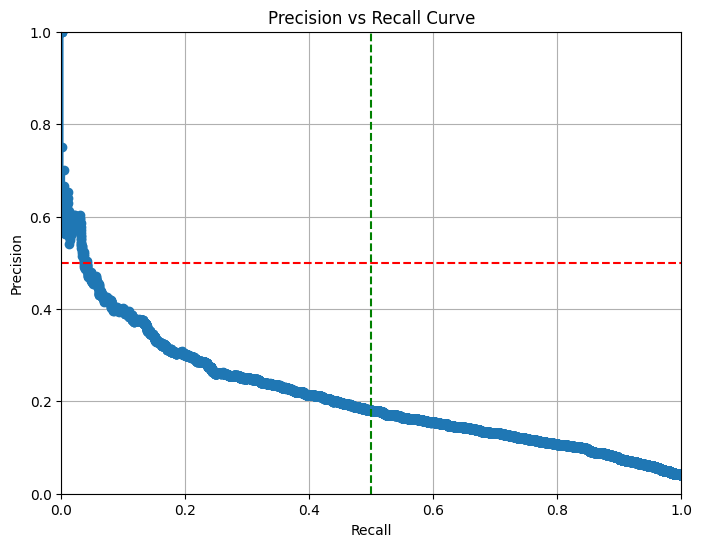

In [23]:
# Get the probabilities for the positive class
y_scores = log_reg_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o')
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.show()

### Synthetic Minority Over-sampling Technique (SMOTE)

In [24]:
from imblearn.over_sampling import SMOTE

# Simulate data with label 1 using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7295590724668835
Confusion Matrix:
[[25957  9724]
 [  341  1195]]


c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


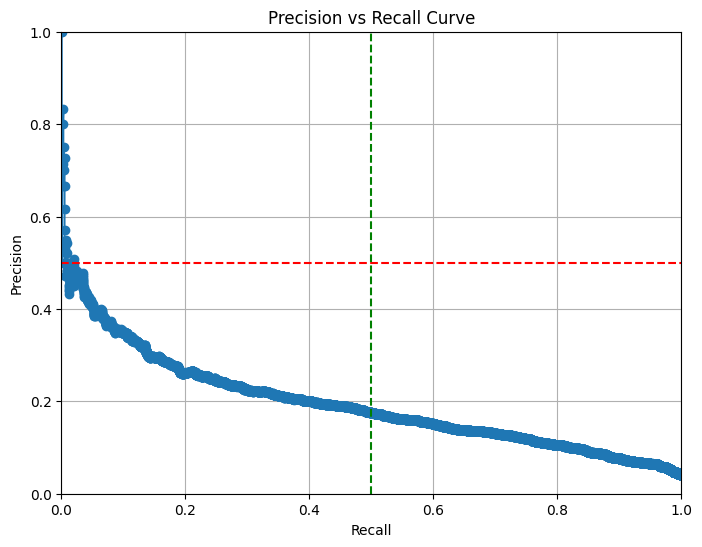

In [25]:
from imblearn.over_sampling import SMOTE

# Simulate data with label 1 using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# New fit
log_reg_model2 = LogisticRegression()
log_reg_model2.fit(X_resampled, y_resampled)


# Get the class prediction
y_pred = log_reg_model2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)

# Get the probabilities for the positive class
y_scores = log_reg_model2.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o')
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.show()

In [22]:
dataset['sequence'].apply(extractSequences)

0         [AAGAC, AGACC, GACCA]
1         [CAAAC, AAACT, AACTG]
2         [GAAAC, AAACA, AACAG]
3         [AGAAC, GAACA, AACAT]
4         [AGGAC, GGACA, GACAA]
                  ...          
121833    [GGGAC, GGACA, GACAT]
121834    [CTGAC, TGACA, GACAC]
121835    [TGGAC, GGACA, GACAC]
121836    [CTGAC, TGACC, GACCA]
121837    [TTGAC, TGACA, GACAT]
Name: sequence, Length: 121838, dtype: object

## Advanced Model: Some neural network

### Feature Engineering & Pre-processing

In [ ]:
# Train-test split

### Model Training

### Model Validation

### Model Prediction

In [26]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming your training data


# Create a sequential model
model = Sequential()

# Input layer (input_shape should match your feature count, which is 27)
model.add(Dense(150, activation='relu', input_shape=(27,)))  # First hidden layer
model.add(Dropout(0.2))  # Optional: dropout layer for regularization

# Second hidden layer
model.add(Dense(32, activation='relu'))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary output

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


# Fit the model to the training data
model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.2)  # Adjust epochs and batch_size as needed

# After fitting, you can save the model if required
# model.save('your_model.keras')

# Print model summary
model.summary()

Epoch 1/10


c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4035/4035 ━━━━━━━━━━━━━━━━━━━━ 4s 788us/step - accuracy: 0.6822 - loss: 0.7685 - val_accuracy: 0.7869 - val_loss: 0.5043
Epoch 2/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 771us/step - accuracy: 0.7645 - loss: 0.4919 - val_accuracy: 0.4996 - val_loss: 0.7897
Epoch 3/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 772us/step - accuracy: 0.7666 - loss: 0.4818 - val_accuracy: 0.5293 - val_loss: 0.7384
Epoch 4/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 768us/step - accuracy: 0.7706 - loss: 0.4776 - val_accuracy: 0.7530 - val_loss: 0.5328
Epoch 5/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 761us/step - accuracy: 0.7764 - loss: 0.4688 - val_accuracy: 0.7623 - val_loss: 0.5328
Epoch 6/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 768us/step - accuracy: 0.7771 - loss: 0.4684 - val_accuracy: 0.7524 - val_loss: 0.5220
Epoch 7/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 765us/step - accuracy: 0.7796 - loss: 0.4655 - val_accuracy: 0.7494 - val_loss: 0.5317
Epoch 8/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 763us/step - accuracy: 0.7812 - loss: 0.46

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 150)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,197 (106.24 KB)

 Trainable params: 9,065 (35.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,132 (70.83 KB)

1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step


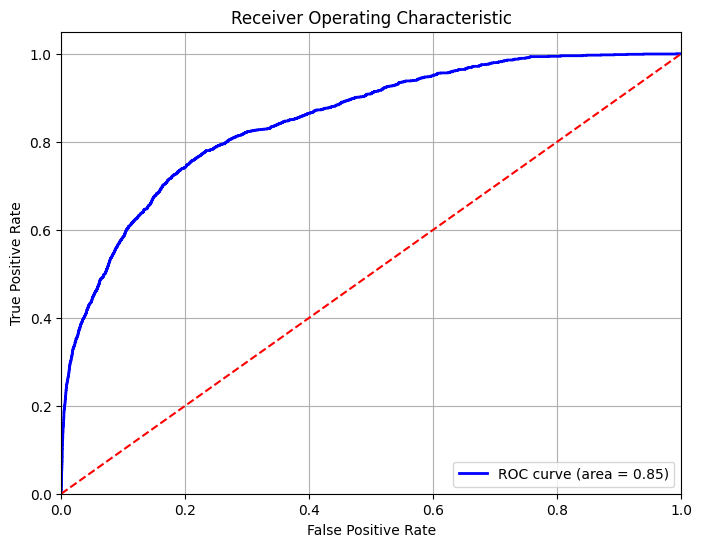

AUC-ROC Score: 0.8493909044583718


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have a test set
# X_test: shape (num_samples, 9)
# y_test: shape (num_samples,) with binary labels (0 or 1)
# Make predictions
predictions = model.predict(X_test)

# Get the predicted probabilities for the positive class
predicted_probabilities = predictions

# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print AUC score
print("AUC-ROC Score:", roc_auc)

1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step


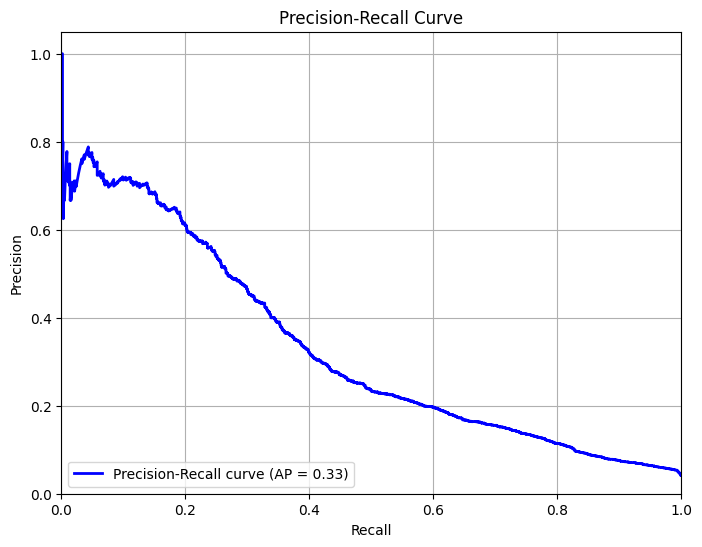

Average Precision Score: 0.3288739352087096


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.models import load_model

# Make predictions on the test set
predicted_probabilities = model.predict(X_test).flatten()  # Flatten to 1D array

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predicted_probabilities)

# Calculate average precision score
average_precision = average_precision_score(y_test, predicted_probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc='lower left')
plt.show()

# Print average precision score
print("Average Precision Score:", average_precision)
